<a href="https://colab.research.google.com/github/lszam/potentials-on/blob/main/PosDocON_Mag_EMAG2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Environment**

In [13]:
!pip install rasterio -q

In [14]:
# 📥 Magnetic data --> EMAG2v3
# GeoTIFFs
!wget -O EMAG2v3_UpCont.tif https://www.ngdc.noaa.gov/geomag/data/EMAG2/EMAG2_V3_20170530/EMAG2_V3_20170530_UpCont.tif
!wget -O EMAG2v3_Sealevel.tif https://www.ngdc.noaa.gov/geomag/data/EMAG2/EMAG2_V3_20170530/EMAG2_V3_20170530_Sealevel.tif

--2025-06-22 15:25:07--  https://www.ngdc.noaa.gov/geomag/data/EMAG2/EMAG2_V3_20170530/EMAG2_V3_20170530_UpCont.tif
Resolving www.ngdc.noaa.gov (www.ngdc.noaa.gov)... 140.172.190.2, 140.172.190.1
Connecting to www.ngdc.noaa.gov (www.ngdc.noaa.gov)|140.172.190.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239593097 (228M) [image/tiff]
Saving to: ‘EMAG2v3_UpCont.tif’

EMAG2v3_UpCont.tif  100%[===================>] 228.49M  18.8MB/s    in 12s     

2025-06-22 15:25:19 (18.4 MB/s) - ‘EMAG2v3_UpCont.tif’ saved [239593097/239593097]

--2025-06-22 15:25:19--  https://www.ngdc.noaa.gov/geomag/data/EMAG2/EMAG2_V3_20170530/EMAG2_V3_20170530_Sealevel.tif
Resolving www.ngdc.noaa.gov (www.ngdc.noaa.gov)... 140.172.190.2, 140.172.190.1
Connecting to www.ngdc.noaa.gov (www.ngdc.noaa.gov)|140.172.190.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239593097 (228M) [image/tiff]
Saving to: ‘EMAG2v3_Sealevel.tif’

EMAG2v3_Sealevel.ti 100%[========

**Importar bibliotecas**

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.fftpack import fft2, ifft2, fftshift

# **2. Preparing mag data**

Read geotiff data

In [33]:
#fname = "EMAG2v3_UpCont.tif"
fname = "EMAG2v3_Sealevel.tif"
with rasterio.open("EMAG2v3_UpCont.tif") as src:
    data = src.read(1).astype(np.float32)
    data[data == -3.4028235e+38] = np.nan  # remover valor "no data" do float32
    dx = src.res[0]

## 🧮

Simplified factor for conversion. Better to convert each cell in the future.

In [34]:
factor = 111 # 1 degree ≈ 111 km

In [35]:
ny, nx = data.shape
x_freq = np.fft.fftfreq(nx, d=dx)
y_freq = np.fft.fftfreq(ny, d=dx)
Xf, Yf = np.meshgrid(x_freq, y_freq)
freq_radius = np.sqrt(Xf**2 + Yf**2)
wavelength_km = 1 / (freq_radius + 1e-12) * factor

## ✂️ Frequency intervals

In [40]:
# Substituir NaNs por zero antes da FFT
data = np.nan_to_num(data, nan=0.0)

In [41]:
fft_data = fft2(data)
fft_data_shifted = fftshift(fft_data)

long_wavelength = wavelength_km > 300
short_wavelength = wavelength_km <= 300

long_filtered = np.real(ifft2(np.fft.ifftshift(fft_data_shifted * long_wavelength)))
short_filtered = np.real(ifft2(np.fft.ifftshift(fft_data_shifted * short_wavelength)))

In [42]:
def diagnostico(name, array):
    print(f"Diagnóstico de: {name}")
    print("  Tem NaN? ", np.isnan(array).any())
    print("  Tem inf? ", np.isinf(array).any())
    print("  Valor mínimo:", np.nanmin(array))
    print("  Valor máximo:", np.nanmax(array))
    print("  Valor médio:", np.nanmean(array))
    print("  Mediana:", np.nanmedian(array))
    print("  % valores = 0:", np.sum(array==0)/array.size*100, "%\n")

# Substituir NaNs e Inf por 0 se necessário
#long_filtered = np.nan_to_num(long_filtered, nan=0.0, posinf=0.0, neginf=0.0)
#short_filtered = np.nan_to_num(short_filtered, nan=0.0, posinf=0.0, neginf=0.0)

diagnostico("Original", data)
diagnostico("Longo (>300km)", long_filtered)
diagnostico("Curto (<300km)", short_filtered)

Diagnóstico de: Original
  Tem NaN?  False
  Tem inf?  False
  Valor mínimo: -3380.9753
  Valor máximo: 8632.614
  Valor médio: -0.61975557
  Mediana: -2.0517793
  % valores = 0: 3.108888477290033 %

Diagnóstico de: Longo (>300km)
  Tem NaN?  False
  Tem inf?  False
  Valor mínimo: -2.0877218
  Valor máximo: 2.0881326
  Valor médio: 1.3878031e-12
  Mediana: -4.4703484e-08
  % valores = 0: 3.4299904646265083e-06 %

Diagnóstico de: Curto (<300km)
  Tem NaN?  False
  Tem inf?  False
  Valor mínimo: -3380.9058
  Valor máximo: 8632.617
  Valor médio: -0.6197553
  Mediana: -2.051907
  % valores = 0: 3.429990464626508e-05 %



In [43]:
def safe_imshow(ax, data, title, cmap='seismic', percent_clip=0.01):
    """Map show avoiding overflow by using percentil values (vmin and vmax)"""
    data_no_nan = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    flat = data_no_nan.flatten()
    flat = flat[~np.isnan(flat)]

    # Determina intervalo robusto ignorando outliers extremos
    vmin = np.percentile(flat, percent_clip*100)
    vmax = np.percentile(flat, (1 - percent_clip)*100)

    im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')
    return im

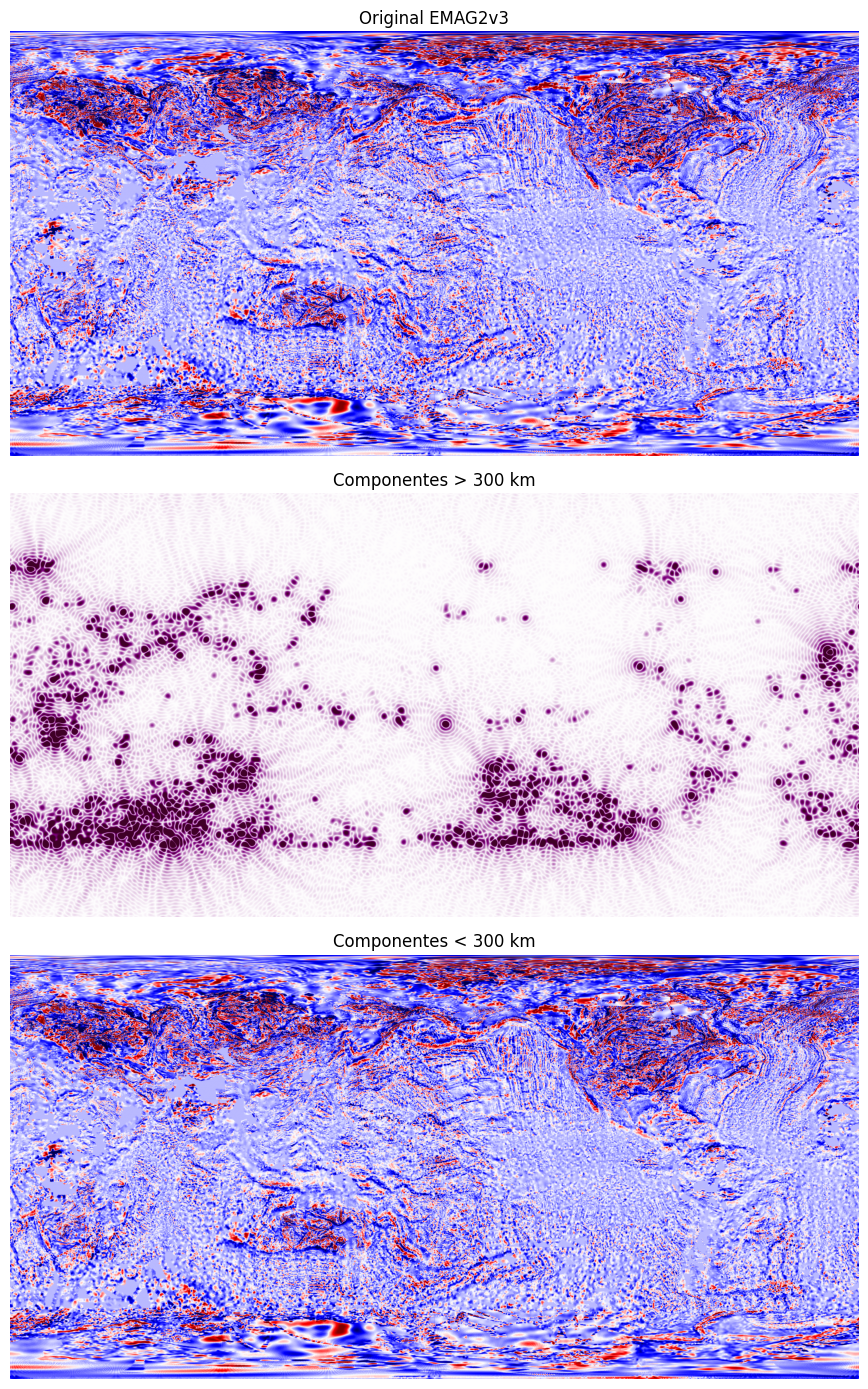

In [44]:
fig, axs = plt.subplots(3, 1, figsize=(10, 14))

safe_imshow(axs[0], data, 'Original EMAG2v3')
safe_imshow(axs[1], long_filtered, 'Componentes > 300 km')
safe_imshow(axs[2], short_filtered, 'Componentes < 300 km')

plt.tight_layout()
plt.show()